In [1]:
!pip3 install lmfit
import lmfit as lm
import numpy as np
import pandas as pd
import glob
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive/')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.7 MB/s eta 0:00:00
Mounted at /content/drive/


Average Numerical Aperture: 0.30871359709533414
Angle of Acceptance 17.981722975649735


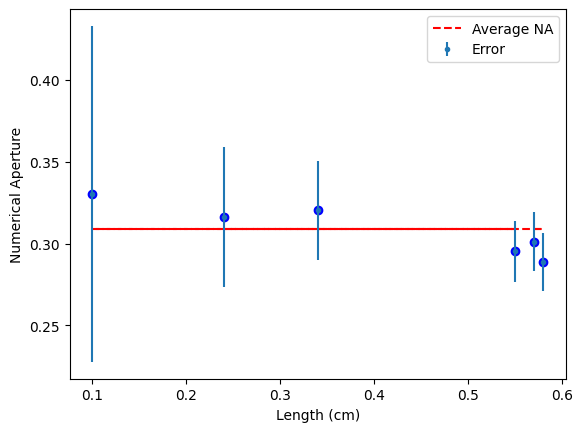

0.03831400218678427


In [2]:
#test 1 - Numerical Aperture  
file_path = '/FIB_Lab/FIB Lab/*.csv'

files = glob.glob(file_path)

df = pd.read_csv('/FIB_Lab/FIB Lab/test1_edited.csv')

#NA = n_i * sin(theta_i)
#n_i = 1 :. NA = sin(theta_i) = r/H, H = sqrt(r**2 + L**2)


r = df['Diameter (cm)']/2
L = df['Length (cm)']
n_i = 1
H = np.sqrt((r**2)+(L**2))
sin_theta_i = r/H
NA = n_i * sin_theta_i

avg_NA = np.mean(NA)
range = np.arcsin(avg_NA) * (180/np.pi)
#print(NA)
print("Average Numerical Aperture:", avg_NA)
print("Angle of Acceptance", range)

test_number = df['Test Number']
mean_NA = np.arange(1, len(df) + 1, 1)

plt.plot(L, NA, 'bo')
# plt.plot(mean_NA, np.ones(len(mean_NA)) * avg_NA, '--r')
plt.plot(L, np.ones(len(mean_NA)) * avg_NA, '--r', label = 'Average NA')

plt.xlabel('Length (cm)')
plt.ylabel('Numerical Aperture')
#plt.title('Measured Numerical Aperture')

#error calculation
#error in H
#dHdL = L/(np.sqrt((r**2)+(L**2)))
sigma_L = 0.02
#dHdr = r/(np.sqrt((r**2)+(L**2)))
sigma_r = 0.01

#sigma_H_squared = (dHdL**2)*(sigma_L**2) + (dHdr**2)*(sigma_r**2)
#sigma_H = np.sqrt(sigma_H_squared)

### do error of r/sqrt(r^2 + L^2)
# not separate of H and r

dNAdr = (L**2)/(((L**2)+(r**2))**1.5)
dNAdL = (L*r)/(((L**2)+(r**2))**1.5)

sigma_error = (dNAdr**2)*(sigma_r**2) + (dNAdL**2)*(sigma_L**2)
sigma_NA = np.sqrt(sigma_error)
#dNAdr = 1/H
#dNAdH = -r/(H**2)
#sigma_NA = (dNAdr**2)*(sigma_r**2) + (dNAdH**2)*(sigma_H**2)



plt.errorbar(L, NA, yerr = sigma_NA, fmt = '.', label = 'Error')
plt.legend()
plt.show()
print(np.mean(sigma_NA))
#dependence/correlation of L - talk about it in write up

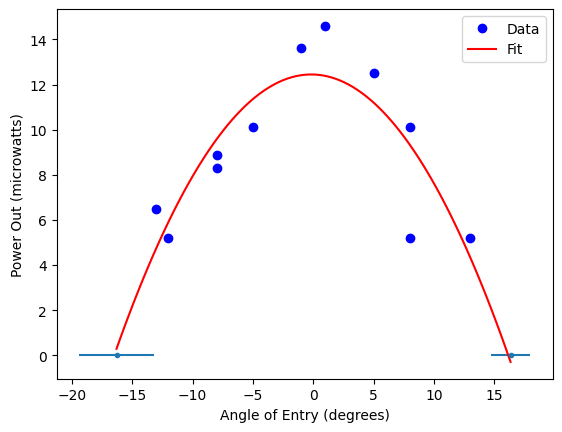

Critical Angle: 16.32218339510374


In [3]:
#test 2 - Critical Angle
file_path = '/FIB_Lab/FIB Lab/*.csv'

files = glob.glob(file_path)

df = pd.read_csv('/FIB_Lab/FIB Lab/test2.csv')

theta_i = 180 - df['Angle of Entry']
power = df['Power Out (microwatts)']

def quadratic(x, a, b, c):
  return a*(x**2) + b*x + c


#



power_idx = (power >= 1) & (power <= 15)
power = power[power_idx]
theta_i = theta_i[power_idx]


model = lm.models.Model(quadratic)

model.set_param_hint('a', value = -1, min = -1000, max = 0)
model.set_param_hint('b', value = 0)
model.set_param_hint('c', value = 15, min = 0, max = 20)

my_params = model.make_params()
#perform fit
result = model.fit(power, params = my_params, x = theta_i)
#print(result.fit_report())

a = result.params['a'].value
b = result.params['b'].value
c = result.params['c'].value

#calculating x values when y = 0 relative to the slight offset of the peak from x = 0; distance from x at ymax
x_1 = -b + np.sqrt(b**2 - 4*a*c)/(2*a)
x_2 = -b - np.sqrt(b**2 - 4*a*c)/(2*a)
x_mid = (np.absolute(x_1) + x_2)/2

#print(result.fit_report())

dfda_1 = 2*a*(x_1**2)
dfdb_1 = x_1
dfdc_1 = 1

row_vec_1 = np.array([dfda_1, dfdb_1, dfdc_1]).reshape((1,3))
col_vec_1 = np.array([dfda_1, dfdb_1, dfdc_1]).reshape((3,1))
#result.covar
err_1 = np.array(np.matmul(row_vec_1, np.matmul(result.covar, col_vec_1)))[0, 0]


dfda_2 = 2*a*(x_2**2)
dfdb_2 = x_2
dfdc_2 = 1

row_vec_2 = np.array([dfda_2, dfdb_2, dfdc_2]).reshape((1,3))
col_vec_2 = np.array([dfda_2, dfdb_2, dfdc_2]).reshape((3,1))

err_2 = np.sqrt(np.matmul(row_vec_2, np.matmul(result.covar, col_vec_2)))[0, 0]

#print(err_res)
x_values = np.array([x_1, x_2])
y_values = np.array([0 ,0])
x_err_vals = np.array([err_1, err_2])
plt.errorbar(x_values, y_values, xerr = x_err_vals, fmt = '.')


plt.xlabel('Angle of Entry (degrees)')
plt.ylabel('Power Out (microwatts)')
#plt.title('Interpolation of Critical Angle')

plt.plot(theta_i, power, 'bo', label='Data')
x_range = np.linspace(x_1, x_2, 100)
plt.plot(x_range, result.eval(x=x_range), 'r-', label='Fit')
plt.legend()

plt.show()


#critical angle
theta_c = x_mid
print("Critical Angle:", theta_c)

#print("Error", err_1)


Attenuation Coefficient 15.513545492363306 Decibels


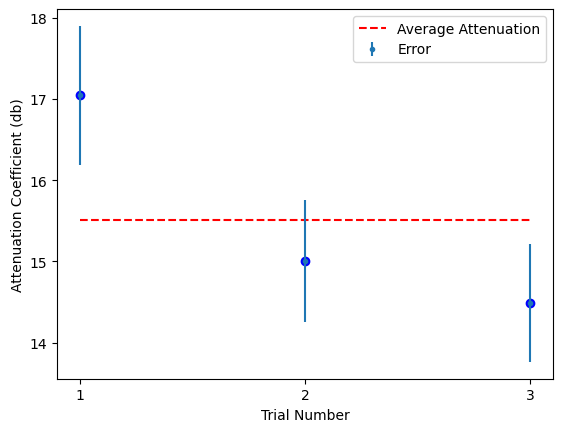

Error 0.7758451869779089


In [4]:
#attenuation coefficient
trial_number = np.array([1, 2, 3])
P0 = np.array([5890.0, 4630.0, 4110.0])
PL = np.array([116.3, 146.2, 146.2])
L = 1.0

sigma_P0 = 0.05
sigma_PL = 0.5
sigma_L = 0.05
dadP0 = 10/(P0*L*np.log(10))
dadPL = -10/(PL*L*np.log(10))
dadL = -10*(np.log10(P0/PL))/(L**2)

#decibels

alpha = (np.log10(P0/PL))*(10/L)
avg_alpha = np.mean(alpha)
print("Attenuation Coefficient", avg_alpha, "Decibels")

alpha_error = (dadP0**2)*(sigma_P0**2) + (dadPL**2)*(sigma_PL**2) + (dadL**2)*(sigma_L**2)
sigma_alpha = np.sqrt(alpha_error)

fig, ax = plt.subplots()
plt.plot(trial_number, alpha, 'bo')
plt.plot(trial_number, np.ones(len(trial_number)) * avg_alpha, '--r', label = 'Average Attenuation')
plt.errorbar(trial_number, alpha, yerr = sigma_alpha, fmt = '.', label = 'Error')
plt.xlabel('Trial Number')
plt.ylabel('Attenuation Coefficient (db)')
#plt.title('Measured Attenuation Coefficient in Decibels')
ax.set_xticks(trial_number)
plt.legend()
plt.show()


print("Error", np.mean(sigma_alpha))